<a href="https://colab.research.google.com/github/Jaseelkt007/Generative_AI_basics/blob/main/Diffusion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Diffusion models

Implementing the DDPM 2020 paper

* This paper is primarly based on discrete-time Markov chain and variational inference (not directly based on SDE or langavin dynamics)

* Some key information :
  * uses discrete forward diffusion process that gradually adds guassian noise
  *  Employs variational lower bound optimization (Heirarchical VAE)
This has two process:

* DDPM is actually learning to predict the noise e that was added at each step
* The neural network predicts the noise used in the forward process.
* Objective is framed as denoising task (not score matching)
* Forward process (Diffusion process) : Change a give input $x_0$ to a Guassian noise $x_t$ ~ $N(0,I)$ by a sequence of first order markov process $q(x_t/x_{t-1})$ ,

* Reverse process (Generation process) : Reverse the diffustion process, by converting the Noise to original data.

# Some relevent papers:
1. Vincet(2011):
   * Established theoritical foundation connecting denoising and score estimation
   * (See my repository for a detailed explanation and connection to Langevin dynamics: [GitHub_repo](https://github.com/Jaseelkt007/Generative_AI_basics/blob/main/Langvin_sampling.ipynb))
2. Song & Ermon (2019)
   * explicitly formulates generative modeling as score matching
   * Uses Langevin dynamics for sampling
3. Song et al. (2021)
   * Shows DDPM is actually learning score function
   *  proves that predicted noise is equivalent to learning score
   *  provide the SDE framework that unifies various diffusion approached


# Diffusion Model Equations

## Forward/noising (fixed, known):

$$q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) = \mathcal{N}\big(\sqrt{\alpha_t}\,\mathbf{x}_{t-1},\, (1-\alpha_t)\mathbf{I}\big), \qquad \alpha_t = 1 - \beta_t$$

## Closed form:

instead of adding noice step by step(slow) , we can jump from clean data x_0 to any noisy version using x_t (like reparametrization,then sample from it)

$$\mathbf{x}_t = \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t}\,\boldsymbol{\epsilon}$$

where:
$$\bar{\alpha}_t = \prod_{s=1}^t \alpha_s, \qquad \boldsymbol{\epsilon} \sim \mathcal{N}(0,I)$$

## Model & loss (ε-prediction):

$$\mathcal{L} = \mathbb{E}_{\mathbf{x}_0,t,\boldsymbol{\epsilon}}\big[\|\boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t,t)\|^2\big]$$

## Reverse/denoising (ancestral DDPM step):

$$p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t) = \mathcal{N}\!\big(\boldsymbol{\mu}_\theta(\mathbf{x}_t,t),\ \sigma_t^2 I\big)$$

where:
$$\boldsymbol{\mu}_\theta = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\ \boldsymbol{\epsilon}_\theta(\mathbf{x}_t,t)\right)$$

$$\sigma_t^2 = \beta_t$$

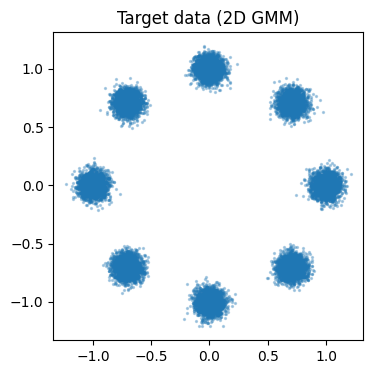

In [2]:
# Create a toy dataset
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class GMM2D(Dataset):
    def __init__(self, n=3000, std=0.06, K=8):
        self.n = n
        angles = np.linspace(0, 2*np.pi , K , endpoint=False)
        centers = np.stack([np.cos(angles), np.sin(angles)], axis=1).astype(np.float32)
        idx = torch.randint(0,K, (n,))
        base = torch.tensor(centers)[idx]
        self.data = base + std*torch.randn(n,2)

    def __len__(self): return self.n
    def __getitem__(self, i): return self.data[i]

dataset = GMM2D(n=20000, std=0.06)
loader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)

pts = dataset.data.numpy()
plt.figure(figsize=(4,4)); plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.3)
plt.axis('equal'); plt.title("Target data (2D GMM)"); plt.show()

$$\mathbf{x}_1 = \sqrt{{\alpha}_t}\,\mathbf{x}_0 + \sqrt{1-{\alpha}_t}\,\boldsymbol{\epsilon}$$
$$\mathbf{x}_2 = \sqrt{{\alpha}_t}\,\mathbf{x}_1 + \sqrt{1-{\alpha}_t}\,\boldsymbol{\epsilon}$$
$$=$$
$$\mathbf{x}_2 = \sqrt{{\alpha}_t}\,(\sqrt{{\alpha}_t}\,\mathbf{x}_0 + \sqrt{1-{\alpha}_t}\,\boldsymbol{\epsilon}) + \sqrt{1-{\alpha}_t}\,\boldsymbol{\epsilon}  $$

$$....$$
$$\mathbf{x}_t = \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t}\,\boldsymbol{\epsilon}$$

$$\bar{\alpha}_t = \prod_{s=1}^t \alpha_s, \qquad \boldsymbol{\epsilon} \sim \mathcal{N}(0,I)$$

In [3]:
# Linear schedular : beta decides how quickly we add noise. the DDPM paper uses linear schedular form 1e-2 to 0.02 over 1000 steps
# betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float32, device=device)

# Cosine beta schedular;
# def cosine_beta_schedule(timesteps, s=0.008):
#     steps = timesteps + 1
#     x = np.linspace(0, timesteps, steps)
#     alphas_cumprod = np.cos(((x/timesteps)+s)/(1+s) * np.pi/2)**2
#     alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
#     betas = 1 - (alphas_cumprod[1:]/alphas_cumprod[:-1])
#     return torch.tensor(np.clip(betas, 0.0001, 0.999), dtype=torch.float32)

T = 200                                # enough for a toy dataset
beta_start, beta_end = 1e-4, 2e-2
betas  = torch.linspace(beta_start, beta_end, T, dtype=torch.float32, device=device)
alphas = 1.0 - betas
abar   = torch.cumprod(alphas, dim=0)

def extract(a, t, shape):
    # gather per-batch t-indexed values and reshape for broadcasting
    out = a.gather(-1, t)
    return out.view(-1, *([1]*(len(shape)-1)))

def q_sample(x0, t, noise=None):
    if noise is None: noise = torch.randn_like(x0)
    return (torch.sqrt(extract(abar, t, x0.shape))*x0
            + torch.sqrt(1-extract(abar, t, x0.shape))*noise, noise)




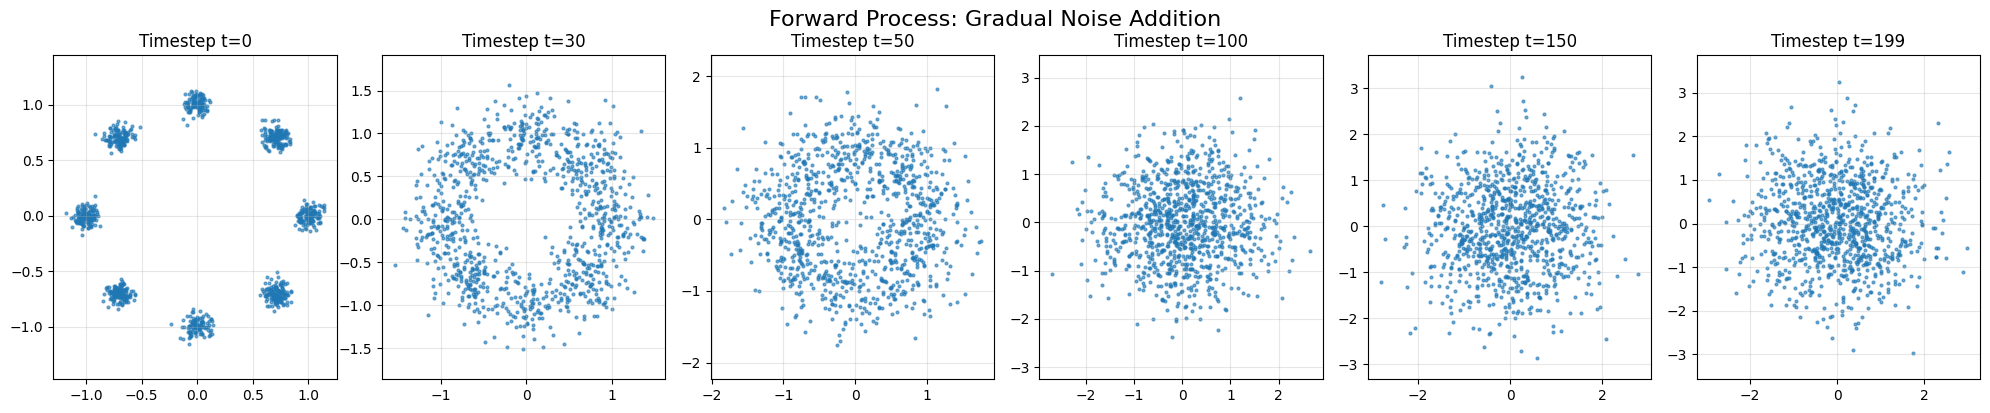

In [4]:
# Visualization of forward process
def visualize_forward_process():
    dataset = GMM2D(n=20000, std=0.06)

    # Sample some data points
    x_0 = dataset.data[:1000].to(device)

    timestep_to_show = [ 0,30 ,50,100 ,150, 199]

    fig, axes = plt.subplots(1, 6, figsize=(20, 4))  # Changed to 1x5 layout

    for i, t in enumerate(timestep_to_show):
        if t == 0:
            x_t = x_0
        else:
            t_tensor = torch.tensor([t] * x_0.shape[0], device=device)
            x_t, _ = q_sample(x_0, t_tensor)

        points = x_t.cpu().numpy()
        axes[i].scatter(points[:, 0], points[:, 1], s=4, alpha=0.6)
        axes[i].set_title(f'Timestep t={t}')
        axes[i].set_xlim(-3, 3)
        axes[i].set_ylim(-3, 3)
        axes[i].axis('equal')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Forward Process: Gradual Noise Addition', fontsize=16, y=1.02)
    plt.show()

# Run the visualization
visualize_forward_process()


# Denoiser network
The denoiser network takes:
- INPUT  : noisy data x_t + timestep t
- OUTPUT : prediction of the noise e that was added

Once we know the noise, we can substract it to get cleaner data!

$$ Goal :ϵ_θ(x_t, t) ≈ ϵ $$

## Time Embedding
The network needs to know WHEN in the diffusion process we are:
- At t=50: only a little noise was added → predict small noise
- At t=900: lots of noise was added → predict large noise

BUT: Neural networks work with continuous values, not discrete timesteps.

Solution: Assign a unique embedding vector to each timestep (embedding)

In [5]:
class SinTimeEmbed(nn.Module):
    def __init__(self, dim, max_period=10000):
        super().__init__(); self.dim=dim; self.max_period=max_period
    def forward(self, t):               # t: (B,) integers in [0, T-1]
        half = self.dim//2
        freqs = torch.exp(-math.log(self.max_period)*torch.arange(half, device=t.device)/half)
        args  = t.float().unsqueeze(1) * freqs.unsqueeze(0) / (T-1)
        emb = torch.cat([torch.cos(args), torch.sin(args)], dim=1)
        if self.dim % 2: emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
        return emb

class DenoiserMLP(nn.Module):
    """
    The neural network that learns to predict noise.
    Architecture:
    1. Time embedding: Convert timestep ->> time vector
    2. Concatenate   : [noisy_data, time_embedding]
    3. MLP           : neural network
    4. Output        : Predicted noise (same shape as input data)
    """
    def __init__(self, hidden=256, tdim=128):
        super().__init__()
        self.time = nn.Sequential(SinTimeEmbed(tdim), nn.Linear(tdim, hidden), nn.SiLU())
        self.net  = nn.Sequential(
            nn.Linear(2+hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden),   nn.SiLU(),
            nn.Linear(hidden, 2)
        )
    def forward(self, x, t):
        h = torch.cat([x, self.time(t)], dim=1)
        return self.net(h)

model = DenoiserMLP().to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=2e-3)


epoch 01: loss=0.5874
epoch 02: loss=0.5078
epoch 03: loss=0.4946
epoch 04: loss=0.4873
epoch 05: loss=0.4879
epoch 06: loss=0.4897
epoch 07: loss=0.4954
epoch 08: loss=0.4850
epoch 09: loss=0.4817
epoch 10: loss=0.4907
epoch 11: loss=0.4828
epoch 12: loss=0.4766
epoch 13: loss=0.4759
epoch 14: loss=0.4653
epoch 15: loss=0.4532
epoch 16: loss=0.4496
epoch 17: loss=0.4384
epoch 18: loss=0.4243
epoch 19: loss=0.4244
epoch 20: loss=0.4143
epoch 21: loss=0.4108
epoch 22: loss=0.4149
epoch 23: loss=0.3954
epoch 24: loss=0.4022
epoch 25: loss=0.3965
epoch 26: loss=0.3964
epoch 27: loss=0.3996
epoch 28: loss=0.3870
epoch 29: loss=0.3980
epoch 30: loss=0.3924
epoch 31: loss=0.3969
epoch 32: loss=0.3873
epoch 33: loss=0.3920
epoch 34: loss=0.3929
epoch 35: loss=0.4010
epoch 36: loss=0.3932
epoch 37: loss=0.3901
epoch 38: loss=0.3891
epoch 39: loss=0.3830
epoch 40: loss=0.3879
epoch 41: loss=0.3905
epoch 42: loss=0.3928
epoch 43: loss=0.3904
epoch 44: loss=0.3856
epoch 45: loss=0.3945
epoch 46: 

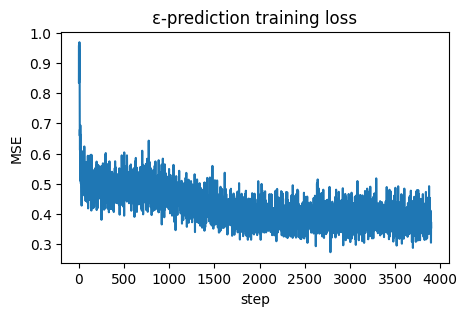

In [6]:
def training_step(x0):
    x0 = x0.to(device)
    B  = x0.size(0)
    t  = torch.randint(0, T, (B,), device=device)
    x_t, noise_added = q_sample(x0, t)
    predicted_noise  = model(x_t, t)
    return F.mse_loss(predicted_noise, noise_added)

loss_hist=[]
for epoch in range(50):
    for batch in loader:
        opt.zero_grad()
        loss = training_step(batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        loss_hist.append(loss.item())
    print(f"epoch {epoch+1:02d}: loss={np.mean(loss_hist[-len(loader):]):.4f}")

plt.figure(figsize=(5,3))
plt.plot(loss_hist); plt.title("ε-prediction training loss"); plt.xlabel("step"); plt.ylabel("MSE"); plt.show()


# Sampling process
* Algorithm 2 from the DDPM paper

Forward process:  $$x₀ → x₁ → x₂ → ... → x_T $$
$$\mathbf{x}_t = \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t}\,\boldsymbol{\epsilon}$$

$$\bar{\alpha}_t = \sqrt{1-\bar{\beta}_t}$$
Reverse process: one step  $$x_T → x_{T-1} $$


Key equation from paper:
$$
p_θ(x_{t-1} | x_t) = N(x_{t-1}; μ_θ(x_t, t), σ_t²I)$$


* Where:
$$
μ_θ(x_t, t) = (1/\sqrt{{\alpha}_t}) × [x_t - (β_t/\sqrt{(1-{\bar\alpha}_t)}) * ε_θ(x_t, t)]$$

This gives us the "denoising" formula:
* reparameterization and sampling
$$x_{t-1} = μ_θ(x_t, t) + \sqrt{β_t} * z, $$
$$ z ∼ N(0,I)$$

* Full Sampling
$$x_T → x_{T-1} → ... → x₁ → x₀ $$
* for t = T-1,...,1 do
   *  $$x_{t-1} = μ_θ(x_t, t) + \sqrt{β_t} * z, $$
* end for

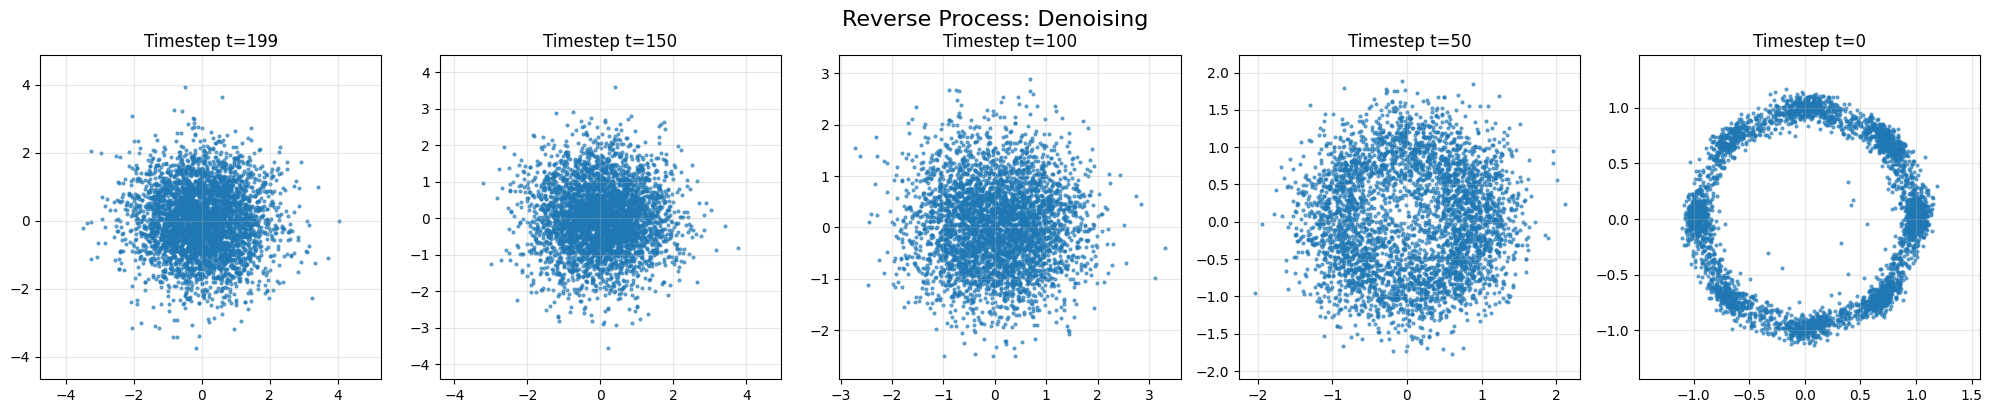

In [8]:
# one reverse step and full sampler
model.eval()
@torch.no_grad()
def p_sample(x_t, t):
    beta_t  = extract(betas,  t, x_t.shape)
    alpha_t = extract(alphas, t, x_t.shape)
    abar_t  = extract(abar,   t, x_t.shape)

    predicted_noise = model(x_t, t)
    mean = (1/torch.sqrt(alpha_t)) * (x_t - (beta_t/torch.sqrt(1-abar_t))*predicted_noise)

    # no noise at t=0
    noise = torch.zeros_like(x_t) if (t==0).all() else torch.randn_like(x_t)
    return mean + torch.sqrt(beta_t)*noise

@torch.no_grad()
def sample(n=4000, record_stages=True):
    x_t = torch.randn(n, 2, device=device)
    stages = []
    # Record stages for timesteps from T-1 down to 0
    time_steps_to_record = sorted([T-1, int(0.75*T), int(0.5*T), int(0.25*T), 0], reverse=True)

    for tt in reversed(range(T)):
        t = torch.full((n,), tt, device=device, dtype=torch.long)
        x_t = p_sample(x_t, t)
        if record_stages and tt in time_steps_to_record:
            stages.append((tt, x_t.detach().cpu().numpy())) # Store timestep and data

    return x_t.detach().cpu().numpy(), stages

# Run the sample function and get the stages
final_samples, stages = sample(n=4000)

# Visualize the denoising stages directly from the sample function output
@torch.no_grad()
def visualize_denoising_stages(stages):
    fig, axes = plt.subplots(1, len(stages), figsize=(20, 4))

    for i, (t_int, xt) in enumerate(stages):
        axes[i].scatter(xt[:, 0], xt[:, 1], s=4, alpha=0.6)
        axes[i].set_title(f'Timestep t={t_int}')
        axes[i].set_xlim(-3, 3)
        axes[i].set_ylim(-3, 3)
        axes[i].axis('equal')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Reverse Process: Denoising', fontsize=16, y=1.02)
    plt.show()

# Visualize the collected stages
visualize_denoising_stages(stages)

To visualize the full denoising trajectory as an animation, we can collect samples at intermediate steps during the reverse process and then use `matplotlib.animation` to create a GIF.

200it [00:09, 21.47it/s]


Saving animation...
Animation saved as ddpm_denoising.gif


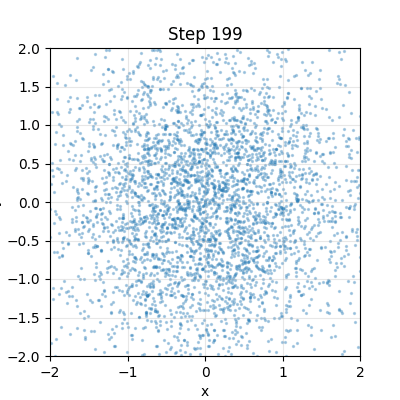

In [9]:
# Reverse Sampling process for animation:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

model.eval() # Set model to evaluation mode

@torch.no_grad()
def sample_animation(n=4000, every=20):
    """
    Run full reverse chain: x_T → ... → x_0 and record frames for animation
    """
    x_t = torch.randn(n,2,device=device)
    frames = []
    # Record frames for timesteps from T-1 down to 0
    for step in tqdm(reversed(range(T))):
        t = torch.full((n,), step, device=device, dtype=torch.long)
        x_t = p_sample(x_t, t)
        if step % every == 0 or step == 0 or step == T-1:
            frames.append((step, x_t.detach().cpu().numpy()))
    return frames

# Run the sample function to get frames for the animation
animation_frames = sample_animation(n=4000, every=10) # Record every 10 steps for a smoother animation

# Create the animation
fig, ax = plt.subplots(figsize=(4,4))
scat = ax.scatter([], [], s=2, alpha=0.3)
ax.set_xlim(-2, 2); ax.set_ylim(-2, 2)
ax.set_title("DDPM denoising trajectory")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.grid(True, alpha=0.3)

def init():
    scat.set_offsets(np.empty((0, 2)))
    return scat,

def update(frame_data):
    step, pts = frame_data
    scat.set_offsets(pts)
    ax.set_title(f"Step {step}")
    return scat,

ani = animation.FuncAnimation(
    fig, update, frames=animation_frames, init_func=init,
    blit=True, interval=100, repeat=False
)

# Save the gif (optional)
print("Saving animation...")
ani.save("ddpm_denoising.gif", writer="pillow", fps=5) # Adjust fps as needed
print("Animation saved as ddpm_denoising.gif")
plt.close(fig)

# To display the gif in the notebook, you can use IPython.display.Image in a new cell
from IPython.display import Image
Image(filename="ddpm_denoising.gif")

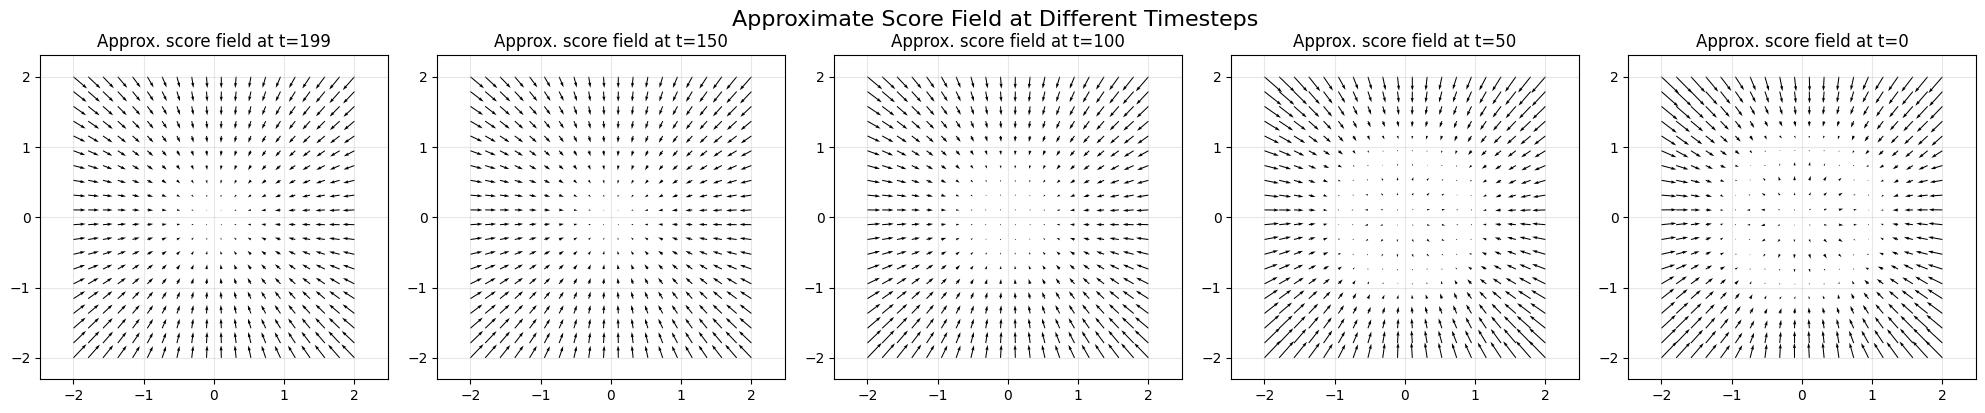

In [10]:
def visualize_score_field(timesteps_to_plot=None, lim=2.0, res=20):
    if timesteps_to_plot is None:
        # Default timesteps to plot if not provided
        timesteps_to_plot = sorted([T-1, int(0.75*T), int(0.5*T), int(0.25*T), 0], reverse=True)

    fig, axes = plt.subplots(1, len(timesteps_to_plot), figsize=(20, 4))

    xs = torch.linspace(-lim, lim, res)
    ys = torch.linspace(-lim, lim, res)
    X, Y = torch.meshgrid(xs, ys, indexing='xy')
    pts = torch.stack([X.flatten(), Y.flatten()], dim=-1).to(device)

    for i, t_int in enumerate(timesteps_to_plot):
        t   = torch.full((pts.size(0),), t_int, device=device, dtype=torch.long)

        with torch.no_grad():
            eps = model(pts, t)
            scale = -1.0/torch.sqrt(1.0 - extract(abar, t, pts.shape))
            score = (scale*eps).cpu().numpy()

        U = score[:,0].reshape(res,res); V = score[:,1].reshape(res,res)
        axes[i].quiver(X.cpu(), Y.cpu(), U, V)
        axes[i].axis('equal')
        axes[i].set_title(f"Approx. score field at t={t_int}")
        axes[i].set_xlim(-lim, lim)
        axes[i].set_ylim(-lim, lim)
        axes[i].grid(True, alpha=0.3)


    plt.tight_layout()
    plt.suptitle('Approximate Score Field at Different Timesteps', fontsize=16, y=1.02)
    plt.show()

# Visualize the score field for the same timesteps as denoising
visualize_score_field()